In [1]:
import os.path as osp

import gudhi as gd
import networkx as nx
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
from analyze_barcode import average_branch_length
from pydmtgraph.dmtgraph import DMTGraph
from pydmtgraph.helper import plotGraph
from compute_barcode import compute_peristence_barcode_from_skeleton
import fl_tissue_model_tools.topology as topo
import fl_tissue_model_tools.preprocessing as prep
from fl_tissue_model_tools import defs, dev_config, data_prep

2022-12-14 16:31:04.301108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 16:31:04.390894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 16:31:04.390911: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 16:31:04.796952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [3]:
def load_img(img_name, dsamp=True, dsize=250):
    '''
        Load the image {img_name} and downsample if {dsamp}
    '''
    # cv.IMREAD_ANYDEPTH loads the image as a 16 bit grayscale image
    img = cv2.imread(img_name, cv2.IMREAD_ANYDEPTH)
    if dsamp:
        return cv2.resize(img, dsize, cv2.INTER_AREA)
    else:
        return img


def load_and_norm(img_name, a, b, mn, mx, dsamp=True, dsize=250):
    '''
        Load the image {img_name},
        normalize the image from the range [{mn}, {mx}] to the range [{a}, {b}],
        and downsample the image to size {dsize}x{dsize} if {dsamp}
    '''
    img = load_img(img_name, dsamp=dsamp, dsize=dsize)
    return prep.min_max_(img, a, b, mn, mx)


def mask_and_threshold(img, circ_mask, pinhole_idx, sd_coef, rs):
    '''
        Apply the circle mask {circ_mask} to the image {img}
        and then perform foreground thresholding on the masked image
    '''
    masked = prep.apply_mask(img, circ_mask).astype(float)
    return prep.exec_threshold(masked, pinhole_idx, sd_coef, rs)

In [4]:
data_dir = 'sample_data'
img_path = osp.join(data_dir, 'image.tif')
mask_path = osp.join(data_dir, 'mask.tif')

In [5]:
mask = cv2.imread(mask_path, 0)
im_og = load_and_norm(img_path, 0, defs.GS_MAX, 0, defs.TIF_MAX, dsamp=False)
mask_idx = np.where(mask == 255)
masked = prep.apply_mask(im_og.copy(), mask.copy()).astype(float)
rs = np.random.RandomState(seed=123)
masked_and_thresholded = prep.exec_threshold(masked.copy(), mask_idx, -1, rs)
blurred_1 = prep.dt_blur(masked_and_thresholded.copy(), 7)
bin_threshed = prep.bin_thresh(blurred_1.copy(), 255)
bin_threshed = bin_threshed.astype(np.float32)
im_blur = prep.blur(bin_threshed.copy(), blur_itr=7)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e465c20e0>
Traceback (most recent call last):
  File "/home/bean/miniconda3/envs/tissue-model-analysis/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bean/miniconda3/envs/tissue-model-analysis/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bean/miniconda3/envs/tissue-model-analysis/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bean/miniconda3/envs/tissue-model-analysis/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [6]:
cv2.imwrite('output/im_og.png', im_og)
cv2.imwrite('output/masked.png', masked)
cv2.imwrite('output/masked_and_thresholded.png', masked_and_thresholded)
cv2.imwrite('output/blurred_1.png', blurred_1)
cv2.imwrite('output/bin_threshed.png', bin_threshed)
cv2.imwrite('output/im_blur.png', im_blur)

True

In [7]:
verts, edges, bc = topo.compute_morse_skeleton_and_barcode(im_blur, np.ones(im_blur.shape), 0.6, 0.2)

1 connected components found




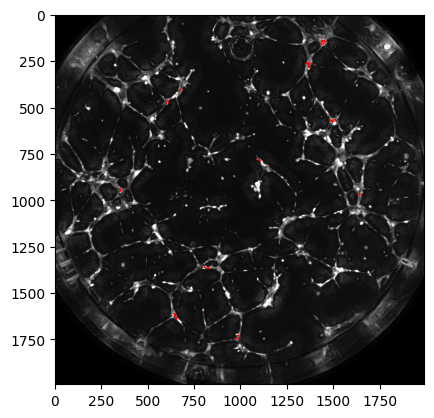

486


In [8]:
fig, ax = plt.subplots()

# add the original image to the plot
ax.imshow(im_og, cmap='gray')

# if the graph is not empty, add it to the plot
if (len(edges) > 0):
    plotGraph(verts , edges, ax)
else:
    print("No graph found")
plt.show()
print(len(verts))

In [14]:
# print the figure
fig.savefig('output/morse_skeleton_vis.png', dpi=500)